In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# Load the dataset
df = pd.read_csv("loan_approval_dataset.csv")

# Display basic information
print("Dataset shape:", df.shape)
df

Dataset shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved


In [2]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64


In [3]:
df.columns = df.columns.str.strip()

# Check unique values and counts of target variable
print("Target variable values:")
print(df['loan_status'].value_counts())

# First, clean the loan_status values to handle potential whitespace and case issues
df['loan_status'] = df['loan_status'].str.strip().str.lower()

# Proper encoding of target variable - ensure it matches exactly
y = df['loan_status'].map({'approved': 1, 'rejected': 0})

# Verify encoding worked correctly
print("\nEncoded target distribution after cleaning:")
print(y.value_counts())

# Features (excluding loan_id and target)
X = df.drop(['loan_id', 'loan_status'], axis=1)

# Preprocessing steps (same as your original code)
numeric_features = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 
                    'cibil_score', 'residential_assets_value', 'commercial_assets_value', 
                    'luxury_assets_value', 'bank_asset_value']
categorical_features = ['education', 'self_employed']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data with stratification to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify split worked correctly
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nValidation set class distribution:")
print(y_val.value_counts())

# Unregularized Logistic Regression Model
unreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, max_iter=1000, random_state=42))
])

unreg_model.fit(X_train, y_train)

y_pred_unreg = unreg_model.predict(X_val)
y_proba_unreg = unreg_model.predict_proba(X_val)[:, 1]

print("\n===== Unregularized Logistic Regression =====")
print(f"Accuracy: {accuracy_score(y_val, y_pred_unreg):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_unreg):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_unreg):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_unreg):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_unreg):.4f}")

Target variable values:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Encoded target distribution after cleaning:
loan_status
1    2656
0    1613
Name: count, dtype: int64

Training set class distribution:
loan_status
1    2125
0    1290
Name: count, dtype: int64

Validation set class distribution:
loan_status
1    531
0    323
Name: count, dtype: int64

===== Unregularized Logistic Regression =====
Accuracy: 0.9133
Precision: 0.9193
Recall: 0.9435
F1 Score: 0.9312
ROC AUC: 0.9724


In [4]:
# Check the original loan_status values
print("Original loan_status values:")
print(df['loan_status'].value_counts())

# Properly encode loan_status (map string values to integers)
y = df['loan_status'].map({'Approved': 1, 'Rejected': 0})

# Verify encoding worked correctly
print("\nEncoded loan_status distribution:")
print(y.value_counts())

Original loan_status values:
loan_status
approved    2656
rejected    1613
Name: count, dtype: int64

Encoded loan_status distribution:
Series([], Name: count, dtype: int64)


In [5]:
# Check for whitespace or case issues
print(df['loan_status'].unique())  # Look for variations like 'approved ' or 'APPROVED'

# Clean values if needed
df['loan_status'] = df['loan_status'].str.strip().str.title()

# Check for NaN values that might be causing problems
print(df['loan_status'].isnull().sum())

['approved' 'rejected']
0


In [6]:
# L1 regularization with grid search
param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}

l1_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42))
])

l1_grid = GridSearchCV(l1_model, param_grid, cv=5, scoring='roc_auc')
l1_grid.fit(X_train, y_train)

print("\n===== L1 (Lasso) Regularization =====")
print(f"Best C: {l1_grid.best_params_['classifier__C']}")

# Evaluate best L1 model
y_pred_l1 = l1_grid.predict(X_val)
y_proba_l1 = l1_grid.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_l1):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_l1):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_l1):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_l1):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_l1):.4f}")


===== L1 (Lasso) Regularization =====
Best C: 1
Accuracy: 0.9122
Precision: 0.9191
Recall: 0.9416
F1 Score: 0.9302
ROC AUC: 0.9726


In [7]:
# L2 regularization with grid search
l2_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', max_iter=1000, random_state=42))
])

l2_grid = GridSearchCV(l2_model, param_grid, cv=5, scoring='roc_auc')
l2_grid.fit(X_train, y_train)

print("\n===== L2 (Ridge) Regularization =====")
print(f"Best C: {l2_grid.best_params_['classifier__C']}")

# Evaluate best L2 model
y_pred_l2 = l2_grid.predict(X_val)
y_proba_l2 = l2_grid.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_l2):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_l2):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_l2):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_l2):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_l2):.4f}")


===== L2 (Ridge) Regularization =====
Best C: 1
Accuracy: 0.9145
Precision: 0.9210
Recall: 0.9435
F1 Score: 0.9321
ROC AUC: 0.9726


In [8]:
# Elastic Net regularization with grid search
elastic_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=2000, random_state=42))
])

elastic_grid = GridSearchCV(elastic_model, elastic_param_grid, cv=5, scoring='roc_auc')
elastic_grid.fit(X_train, y_train)

print("\n===== Elastic Net Regularization =====")
print(f"Best parameters: {elastic_grid.best_params_}")

# Evaluate best Elastic Net model
y_pred_elastic = elastic_grid.predict(X_val)
y_proba_elastic = elastic_grid.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_elastic):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_elastic):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_elastic):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_elastic):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_elastic):.4f}")


===== Elastic Net Regularization =====
Best parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.9}
Accuracy: 0.9110
Precision: 0.9174
Recall: 0.9416
F1 Score: 0.9294
ROC AUC: 0.9726


In [9]:
# Create DataFrame with performance metrics
metrics = pd.DataFrame({
    'Model': ['Unregularized', 'L1 (Lasso)', 'L2 (Ridge)', 'Elastic Net'],
    'Accuracy': [
        accuracy_score(y_val, y_pred_unreg),
        accuracy_score(y_val, y_pred_l1),
        accuracy_score(y_val, y_pred_l2),
        accuracy_score(y_val, y_pred_elastic)
    ],
    'Precision': [
        precision_score(y_val, y_pred_unreg),
        precision_score(y_val, y_pred_l1),
        precision_score(y_val, y_pred_l2),
        precision_score(y_val, y_pred_elastic)
    ],
    'Recall': [
        recall_score(y_val, y_pred_unreg),
        recall_score(y_val, y_pred_l1),
        recall_score(y_val, y_pred_l2),
        recall_score(y_val, y_pred_elastic)
    ],
    'F1 Score': [
        f1_score(y_val, y_pred_unreg),
        f1_score(y_val, y_pred_l1),
        f1_score(y_val, y_pred_l2),
        f1_score(y_val, y_pred_elastic)
    ],
    'ROC AUC': [
        roc_auc_score(y_val, y_proba_unreg),
        roc_auc_score(y_val, y_proba_l1),
        roc_auc_score(y_val, y_proba_l2),
        roc_auc_score(y_val, y_proba_elastic)
    ]
})

print("\n===== Model Performance Comparison =====")
print(metrics.set_index('Model').round(4))


===== Model Performance Comparison =====
               Accuracy  Precision  Recall  F1 Score  ROC AUC
Model                                                        
Unregularized    0.9133     0.9193  0.9435    0.9312   0.9724
L1 (Lasso)       0.9122     0.9191  0.9416    0.9302   0.9726
L2 (Ridge)       0.9145     0.9210  0.9435    0.9321   0.9726
Elastic Net      0.9110     0.9174  0.9416    0.9294   0.9726


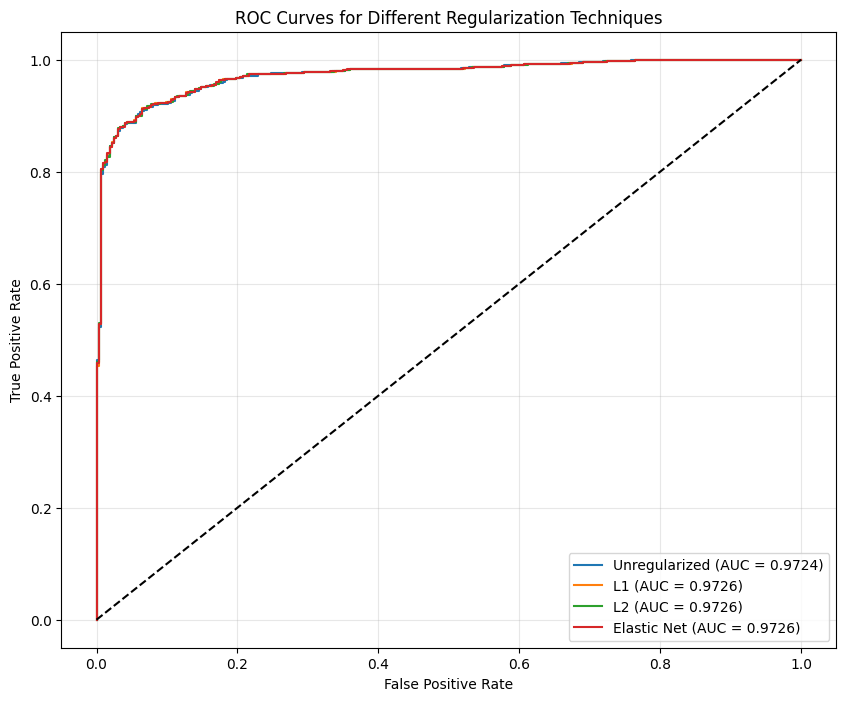

In [10]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot for unregularized model
fpr_unreg, tpr_unreg, _ = roc_curve(y_val, y_proba_unreg)
plt.plot(fpr_unreg, tpr_unreg, label=f'Unregularized (AUC = {roc_auc_score(y_val, y_proba_unreg):.4f})')

# Plot for L1 model
fpr_l1, tpr_l1, _ = roc_curve(y_val, y_proba_l1)
plt.plot(fpr_l1, tpr_l1, label=f'L1 (AUC = {roc_auc_score(y_val, y_proba_l1):.4f})')

# Plot for L2 model
fpr_l2, tpr_l2, _ = roc_curve(y_val, y_proba_l2)
plt.plot(fpr_l2, tpr_l2, label=f'L2 (AUC = {roc_auc_score(y_val, y_proba_l2):.4f})')

# Plot for Elastic Net model
fpr_elastic, tpr_elastic, _ = roc_curve(y_val, y_proba_elastic)
plt.plot(fpr_elastic, tpr_elastic, label=f'Elastic Net (AUC = {roc_auc_score(y_val, y_proba_elastic):.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Regularization Techniques')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


===== Feature Selection Analysis =====
Number of non-zero coefficients:
Unregularized: 11/11
L1 (Lasso): 11/11
L2 (Ridge): 11/11
Elastic Net: 11/11


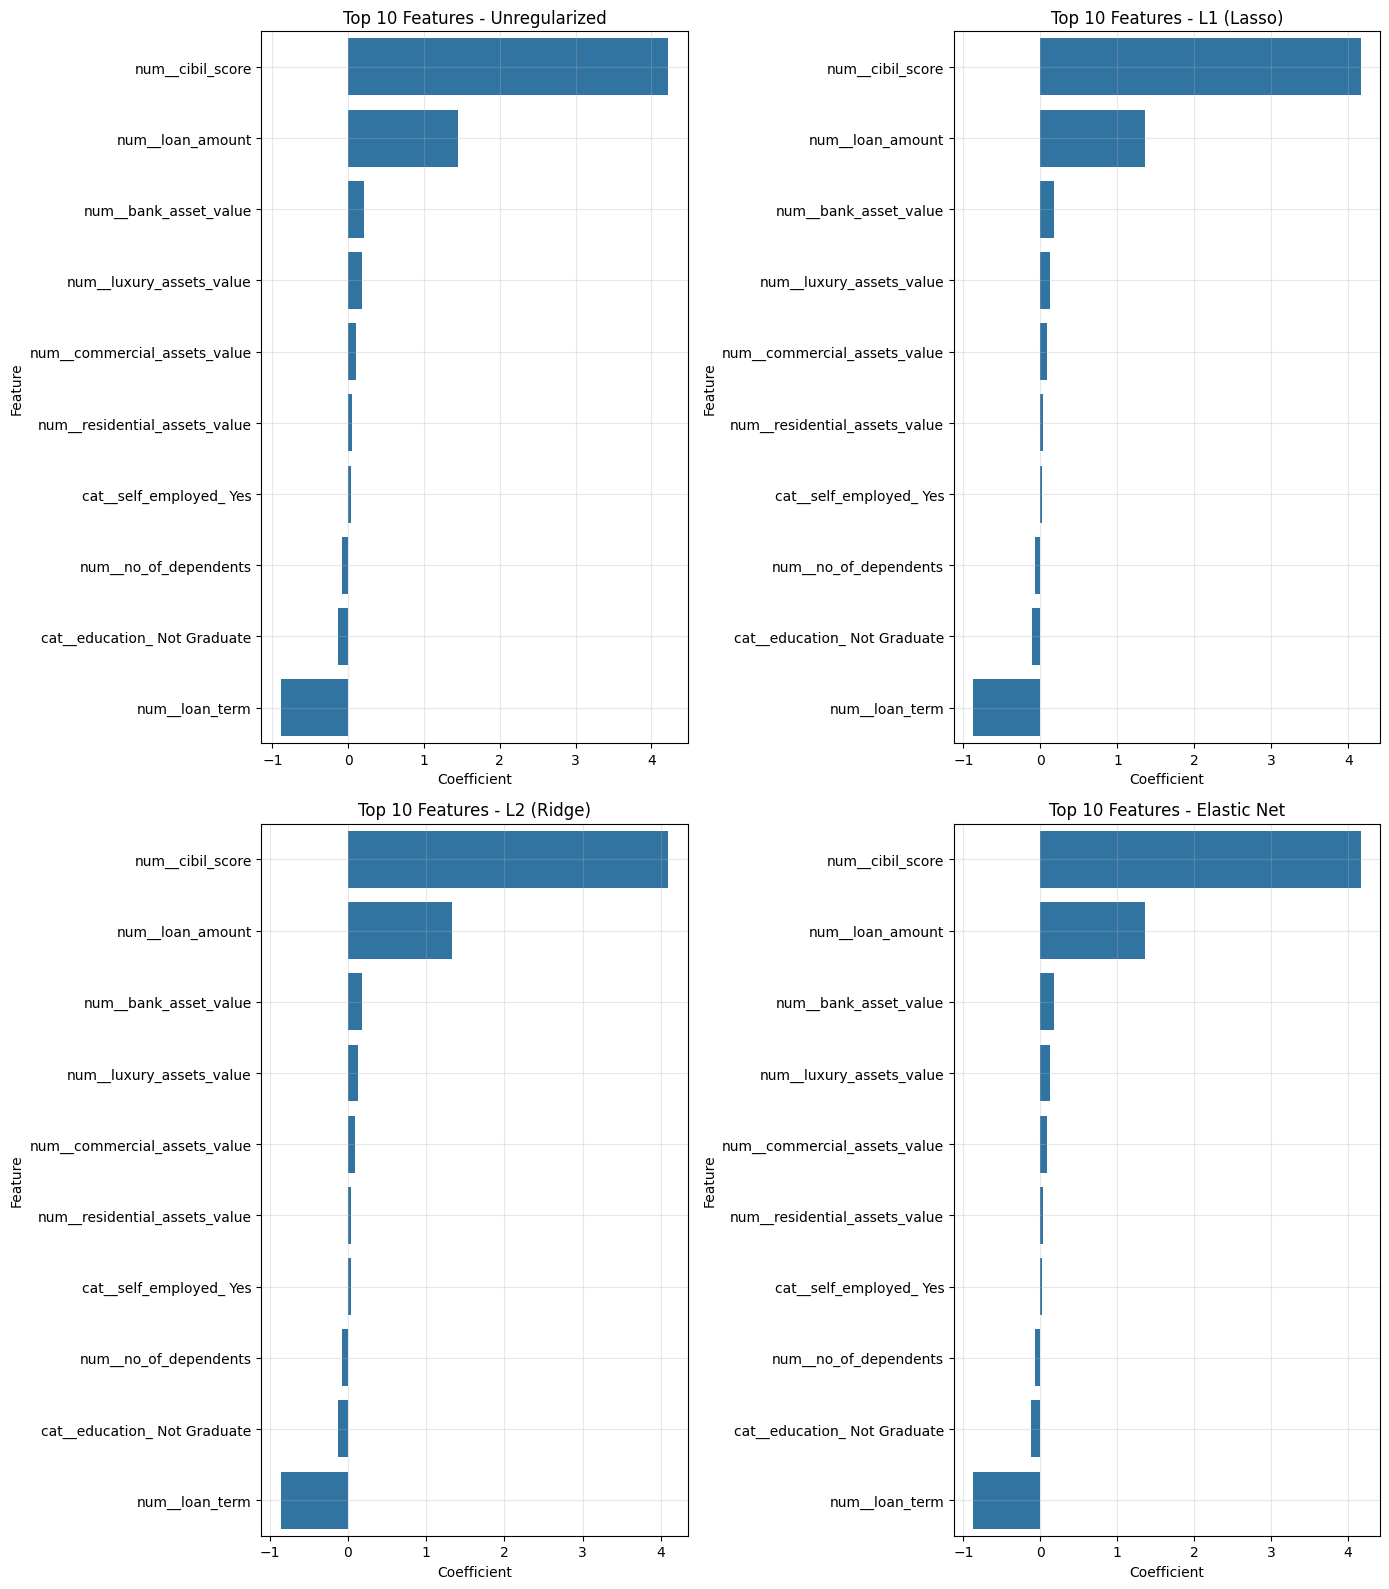

In [11]:
# Function to extract feature names and coefficients
def get_feature_importances(model):
    preprocessor = model.named_steps['preprocessor']
    classifier = model.named_steps['classifier']
    
    # Get feature names after preprocessing
    features = preprocessor.get_feature_names_out()
    
    # Get coefficients
    coefs = classifier.coef_[0]
    
    return pd.DataFrame({'Feature': features, 'Coefficient': coefs}).sort_values('Coefficient', ascending=False)

# Get feature importances for each model
unreg_features = get_feature_importances(unreg_model)
l1_features = get_feature_importances(l1_grid.best_estimator_)
l2_features = get_feature_importances(l2_grid.best_estimator_)
elastic_features = get_feature_importances(elastic_grid.best_estimator_)

# Count non-zero coefficients
non_zero_counts = {
    'Unregularized': (abs(unreg_features['Coefficient']) > 1e-5).sum(),
    'L1 (Lasso)': (abs(l1_features['Coefficient']) > 1e-5).sum(),
    'L2 (Ridge)': (abs(l2_features['Coefficient']) > 1e-5).sum(),
    'Elastic Net': (abs(elastic_features['Coefficient']) > 1e-5).sum()
}

print("\n===== Feature Selection Analysis =====")
print("Number of non-zero coefficients:")
for model, count in non_zero_counts.items():
    print(f"{model}: {count}/{len(unreg_features)}")

# Plot top features for each model
plt.figure(figsize=(14, 16))

plt.subplot(2, 2, 1)
sns.barplot(x='Coefficient', y='Feature', data=unreg_features.head(10))
plt.title('Top 10 Features - Unregularized')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sns.barplot(x='Coefficient', y='Feature', data=l1_features.head(10))
plt.title('Top 10 Features - L1 (Lasso)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
sns.barplot(x='Coefficient', y='Feature', data=l2_features.head(10))
plt.title('Top 10 Features - L2 (Ridge)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
sns.barplot(x='Coefficient', y='Feature', data=elastic_features.head(10))
plt.title('Top 10 Features - Elastic Net')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

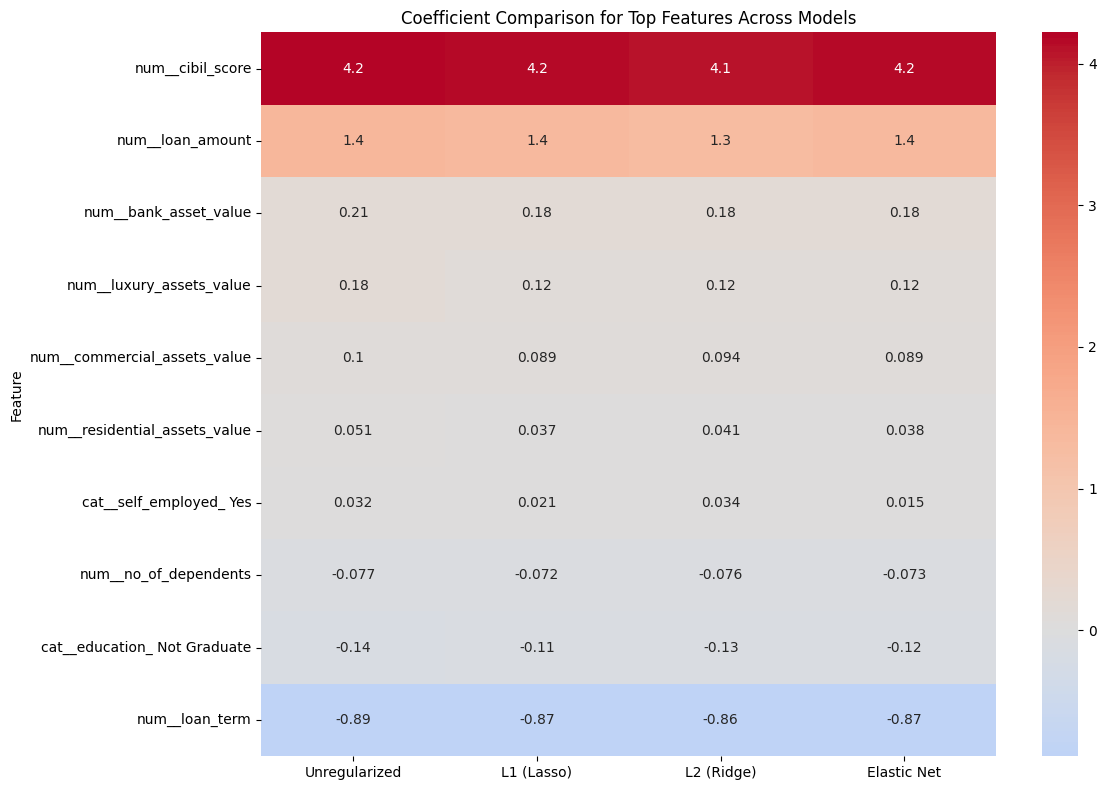

In [12]:
# Get top 10 features from unregularized model
top_features = unreg_features.head(10)['Feature'].tolist()

# Create comparison DataFrame
coef_comparison = pd.DataFrame({
    'Feature': top_features,
    'Unregularized': unreg_features.set_index('Feature').loc[top_features, 'Coefficient'].values,
    'L1 (Lasso)': l1_features.set_index('Feature').loc[top_features, 'Coefficient'].values,
    'L2 (Ridge)': l2_features.set_index('Feature').loc[top_features, 'Coefficient'].values,
    'Elastic Net': elastic_features.set_index('Feature').loc[top_features, 'Coefficient'].values
})

# Set Feature as index
coef_comparison.set_index('Feature', inplace=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(coef_comparison, annot=True, cmap='coolwarm', center=0)
plt.title('Coefficient Comparison for Top Features Across Models')
plt.tight_layout()
plt.show()